In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import requests

In [2]:
dir = '/home/user/Desktop/Datos/'
#dir = '/Users/antoniomendez/Desktop/Tesis/Datos/datos_limpios/'

In [42]:
def count_trips_mibici(data_user):
    viajes_user = data_user.groupby([data_user[['Origen_Id', 'Destino_Id']].min(axis=1), data_user[['Origen_Id', 'Destino_Id']].max(axis=1)]).size().reset_index(name='counts')
    viajes_user.columns = ['Est_A', 'Est_B', 'counts']
    total = viajes_user['counts'].sum()
    viajes_user['prob'] = viajes_user['counts']/total
    return viajes_user

def leer_matriz(nombre_archivo):
    matriz = []
    with open(nombre_archivo, 'r') as archivo:
        archivo.readline()
        archivo.readline()
        for linea in archivo:
            fila = [float(valor) for valor in linea.strip().split()]
            matriz.append(fila)
    return matriz

def encontrar_estacion(est, matriz):
    for i in range(len(matriz)):
        if matriz[i][0] == est:
            return matriz[i][1], matriz[i][2]
    return None, None

In [37]:
def dijkstra(data_user, n_begin, n_end):
    """
    esta funcion calcula el camino mas corto entre dos nodos de una red 
    Args:
        data_user: dataframe de pandas con las columnas 'Est_A', 'Est_B' y 'counts' (en formato de la funcion count_trips_mibici)
        n_begin: id de la estacion donde comienza el viaje
        n_end: id de la estacion donde termina el viaje
    Returns:
        sp: lista con los nodos que forman el camino mas corto entre n_begin y n_end
        min_distance: distancia minima entre n_begin y n_end
    """
    nodes = list(set(data_user['Est_A'].unique().tolist() + data_user['Est_B'].unique().tolist()))
    n_nodes = len(nodes)
    distances = {node: np.inf for node in nodes}
    parent = {node: None for node in nodes}
    visited = {node: False for node in nodes}

    # distancia inicial en 0
    distances[n_begin] = 0 

    for _ in range(n_nodes - 1):
        # nodo no visitado con menor distancia
        u = min((node for node in distances if not visited[node]), key=lambda node: distances[node], default=None)
        
        if u is None or distances[u] == np.inf:
            break  # si no hay nodos a los cuales ir
        
        visited[u] = True
        
        # actualizacion de distancias
        neighbors = data_user[(data_user['Est_A'] == u) | (data_user['Est_B'] == u)]
        for _, row in neighbors.iterrows():
            v = row['Est_B'] if row['Est_A'] == u else row['Est_A']
            if not visited[v]:
                new_dist = distances[u] + row['counts']
                if new_dist < distances[v]:
                    distances[v] = new_dist
                    parent[v] = u  # actualizar padre

    # construccion del camino mas corto
    sp = []
    current = n_end
    while current is not None:
        sp.insert(0, current)
        current = parent[current]

    # en el caso en el que no se haya encontrado camino
    if sp[0] != n_begin:
        return None, np.inf

    return sp, distances[n_end]

In [38]:
def compute_entropy(counter_user):
    '''
    args:
    counter_user: DataFrame with columns Est_A, Est_B, counts, prob given by count_trips_mibici by a specific user
    total_counter: DataFrame with columns Est_A, Est_B, counts, prob given by count_trips_mibici by all users
    return:
    entropy: float with the entropy
    '''
    entropy = 0
    for i in range(len(counter_user)):
        prob = counter_user.iloc[i]['prob']
        entropy -= prob * np.log(prob)
    return entropy

In [63]:
def route_factor(data_user, est, trad = True):
    """
    Esta funcion calcula el factor de ruta de un usuario
    Args:
        data_user: dataframe de pandas con las columnas 'Est_A', 'Est_B' y 'counts' (en formato de la funcion count_trips_mibici)
    Returns:
        route_factor: factor de ruta del usuario
    """
    nodes = list(set(data_user['Est_A'].unique().tolist() + data_user['Est_B'].unique().tolist()))
    n_nodes = len(nodes)
    if n_nodes <= 1:
        return 0
    total = 0
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            sp, min_distance = dijkstra(data_user, nodes[i], nodes[j])
            if sp is not None:
                latA, lonA = encontrar_estacion(nodes[i], est)
                latB, lonB = encontrar_estacion(nodes[j], est)
                if trad:
                    total += min_distance / np.sqrt((latA - latB)**2 + (lonA - lonB)**2)
                else:
                    total += np.sqrt((latA - latB)**2 + (lonA - lonB)**2) / min_distance
    return total / (n_nodes * (n_nodes - 1))

In [7]:
# Load data
data_2019 = pd.read_csv(f'{dir}mibici/2019.csv')
data = data_2019[data_2019['Inicio_del_viaje'].str.startswith('2019-01')]
del data_2019

In [41]:
estaciones = leer_matriz(f'{dir}Adj_mibici/matrices_estaciones/est_2019.txt')

In [10]:
users_counts = data['Usuario_Id'].value_counts()
users = users_counts[users_counts > 5].index.tolist()

In [11]:
data_1 = data[data['Inicio_del_viaje'].str.startswith('2019-01-01')]

In [21]:
users_1_counts = data_1['Usuario_Id'].value_counts()
users_1 = users_1_counts[users_1_counts.index.isin(users)].index.tolist()

In [64]:
proj_1 = []
for user in users_1:
    data_user = data_1[data_1['Usuario_Id'] == user]
    counter_user = count_trips_mibici(data_user)
    entropy = compute_entropy(counter_user)
    rf = route_factor(counter_user, estaciones)
    proj_1.append([entropy, rf])

In [65]:
proj_1_2 = []
for user in users_1:
    data_user = data_1[data_1['Usuario_Id'] == user]
    counter_user = count_trips_mibici(data_user)
    entropy = compute_entropy(counter_user)
    rf = route_factor(counter_user, estaciones, trad=False)
    proj_1_2.append([entropy, rf])

In [66]:
len(proj_1)

1186

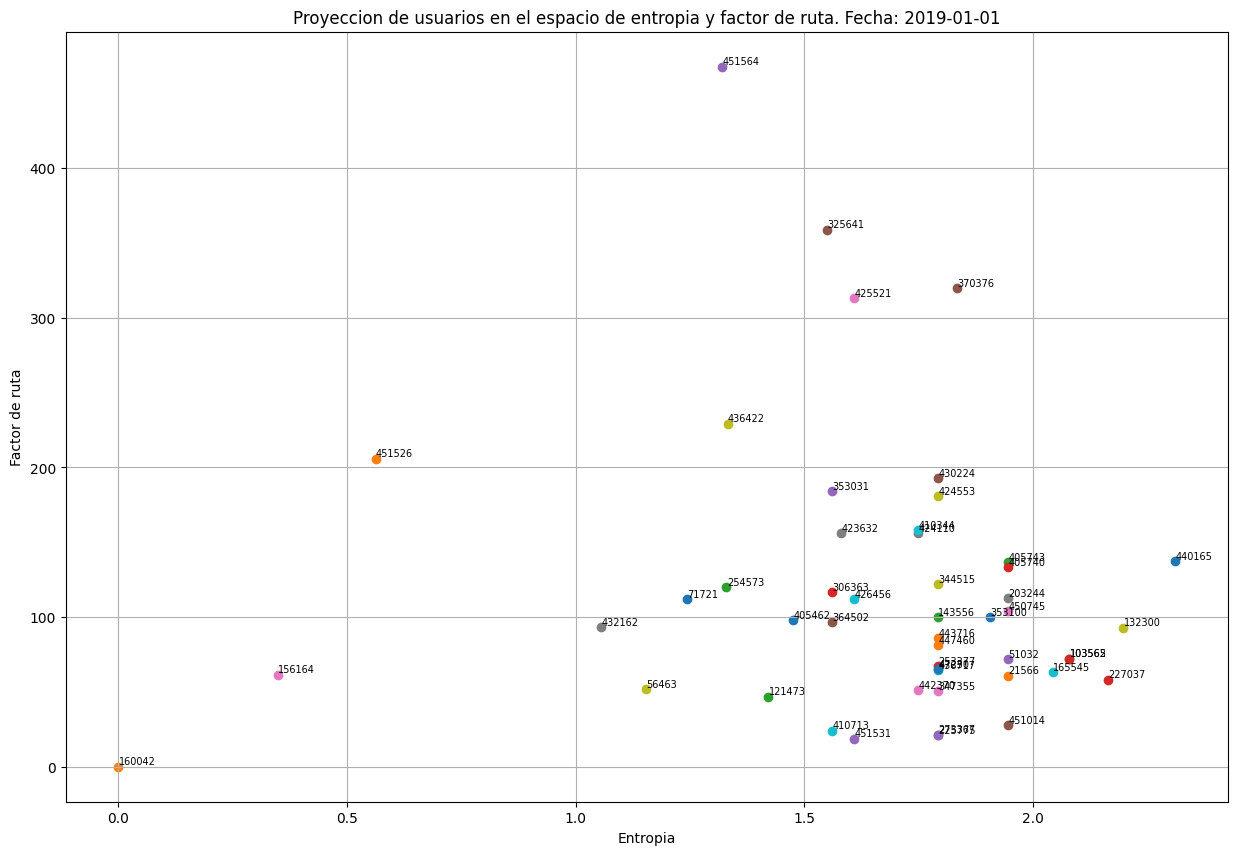

In [67]:
plt.figure(figsize=(15, 10))
for user in users_1[:50]:
    plt.scatter(proj_1[users_1.index(user)][0], proj_1[users_1.index(user)][1])
    plt.text(proj_1[users_1.index(user)][0] + 0.001, proj_1[users_1.index(user)][1] + 0.001, str(user), fontsize=7, ha='left', va='bottom')
plt.xlabel('Entropia')
plt.ylabel('Factor de ruta')
plt.title(f'Proyeccion de usuarios en el espacio de entropia y factor de ruta. Fecha: {data_1.iloc[0]["Inicio_del_viaje"][:10]}')
plt.grid()
plt.show()

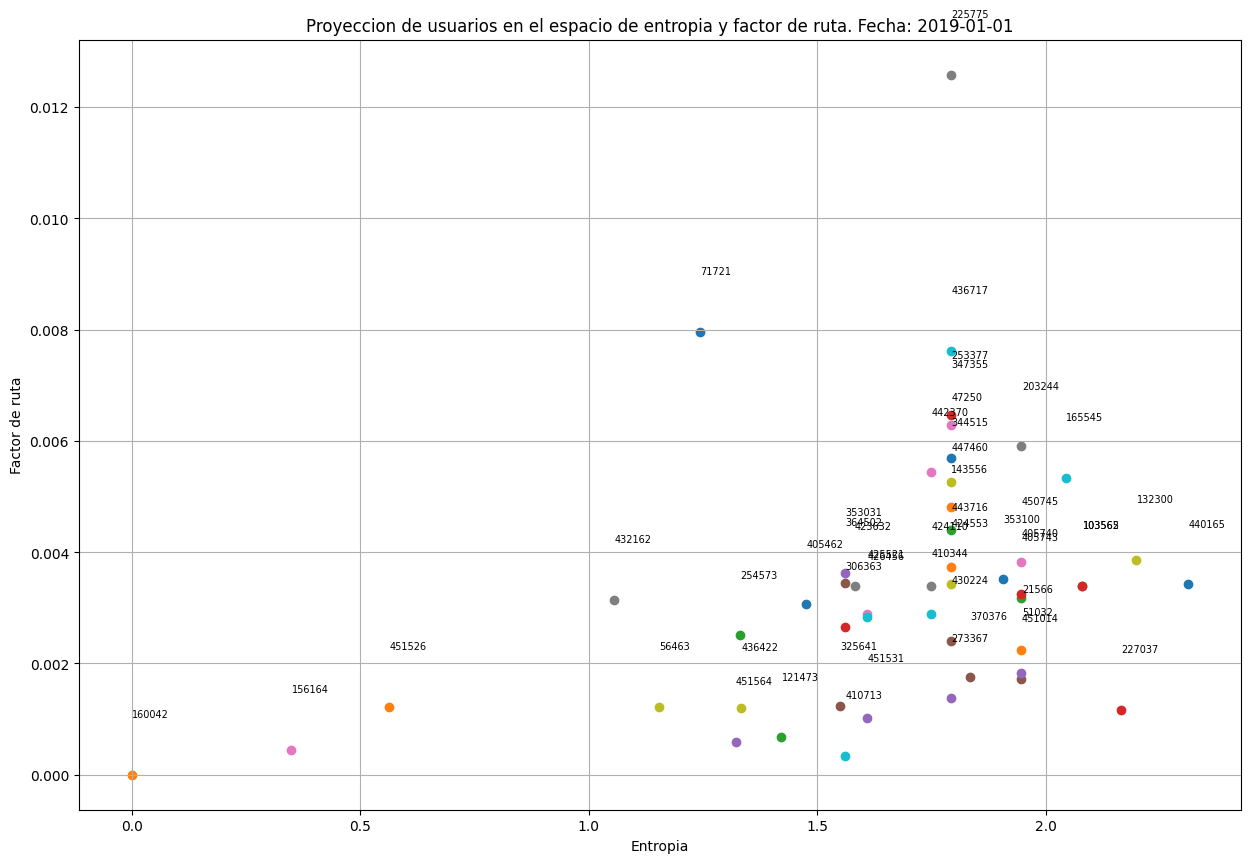

In [68]:
plt.figure(figsize=(15, 10))
for user in users_1[:50]:
    plt.scatter(proj_1_2[users_1.index(user)][0], proj_1_2[users_1.index(user)][1])
    plt.text(proj_1_2[users_1.index(user)][0] + 0.001, proj_1_2[users_1.index(user)][1] + 0.001, str(user), fontsize=7, ha='left', va='bottom')
plt.xlabel('Entropia')
plt.ylabel('Factor de ruta')
plt.title(f'Proyeccion de usuarios en el espacio de entropia y factor de ruta. Fecha: {data_1.iloc[0]["Inicio_del_viaje"][:10]}')
plt.grid()
plt.show()

In [70]:
proj = []
for user in users[:50]:
    data_user = data[data['Usuario_Id'] == user]
    counter_user = count_trips_mibici(data_user)
    entropy = compute_entropy(counter_user)
    rf = route_factor(counter_user, estaciones)
    proj.append([entropy, rf])

KeyboardInterrupt: 

In [ ]:
proj_2 = []
for user in users:
    data_user = data[data['Usuario_Id'] == user]
    counter_user = count_trips_mibici(data_user)
    entropy = compute_entropy(counter_user)
    rf = route_factor(counter_user, estaciones, trad=False)
    proj_2.append([entropy, rf])

In [ ]:
plt.figure(figsize=(15, 10))
for user in users[:50]:
    plt.scatter(proj[users.index(user)][0], proj[users.index(user)][1])
    plt.text(proj[users.index(user)][0] + 0.001, proj[users.index(user)][1] + 0.001, str(user), fontsize=7, ha='left', va='bottom')
plt.xlabel('Entropia')
plt.ylabel('Factor de ruta')
plt.title(f'Proyeccion de usuarios en el espacio de entropia y factor de ruta.')
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
for user in users[:50]:
    plt.scatter(proj_2[users.index(user)][0], proj_2[users.index(user)][1])
    plt.text(proj_2[users.index(user)][0] + 0.001, proj_2[users.index(user)][1] + 0.001, str(user), fontsize=7, ha='left', va='bottom')
plt.xlabel('Entropia')
plt.ylabel('Factor de ruta')
plt.title(f'Proyeccion de usuarios en el espacio de entropia y factor de ruta.')
plt.grid()